In [1]:
import pandas as pd
path = "../dataset/chapter_3/"

In [2]:
ulog = pd.read_csv(path + "use_log.csv")
ulog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [3]:
c_mas = pd.read_csv(path + "customer_master.csv")
c_mas.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [4]:
cl_mas = pd.read_csv(path + "class_master.csv")
cl_mas.head()

,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [5]:
cam_mas = pd.read_csv(path + "campaign_master.csv")
cam_mas.head()

,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


In [6]:
c_join = pd.merge(c_mas, cl_mas, on = "class", how = "left")
c_join = pd.merge(c_join, cam_mas, on = "campaign_id", how = "left")
c_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [7]:
c_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

In [8]:
c_join["start_date"] = pd.to_datetime(c_join["start_date"])
c_join["end_date"] = pd.to_datetime(c_join["end_date"])
c_new = c_join.loc[(c_join["end_date"] >= pd.to_datetime("20190331")) | 
                   c_join["end_date"].isnull()] # isnull() = isna()
print(c_new.shape)

(2953, 11)


## 履歴データからの集計

In [9]:
ulog["usedate"] = pd.to_datetime(ulog["usedate"])
ulog["年月"] = ulog["usedate"].dt.strftime("%Y%m")
ulog_month = ulog.groupby(["年月", "customer_id"], as_index = False).count() # as_index: 指標をindexにするか
ulog_month.rename(columns = {"log_id":"count"}, inplace = True) # inplace: 元のオブジェクトを置き換えるか
del ulog_month["usedate"]
ulog_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [10]:
ulog_cus = ulog_month.groupby("customer_id").agg(["mean", "median", "max", "min"])["count"]
ulog_cus = ulog_cus.reset_index(drop = False) # drop:元のindexを消すか, ここではcus_id
ulog_cus.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


In [11]:
ulog.head()
ulog["weekday"] = ulog["usedate"].dt.weekday # 曜日を算出, 月:0, 火:1, ..
ulog_week = ulog.groupby(["customer_id", "年月", "weekday"], as_index = False).count()
ulog_week.rename(columns = {"log_id":"count"}, inplace = True)
del ulog_week["usedate"]
ulog_week.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [12]:
ulog_week = ulog_week.groupby("customer_id", as_index = False).max()[["customer_id", "count"]]
ulog_week["routine_flg"] = 0
ulog_week["routine_flg"] = ulog_week["routine_flg"].where(ulog_week["count"]<4, 1)
# pandasのwhereはFalseに代入
ulog_week.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [13]:
c_join = pd.merge(c_join, ulog_cus, on = "customer_id", how = "left")
c_join = pd.merge(c_join, ulog_week[["customer_id", "routine_flg"]], on = "customer_id", how = "left")
c_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


## 会員期間の算出 (end_dateの欠損値補完)

In [14]:
from dateutil.relativedelta import relativedelta # datetime型の加減算を行うためのライブラリ
c_join["calc_date"] = c_join["end_date"]
c_join["calc_date"] = c_join["calc_date"].fillna(pd.to_datetime("20190430")) # 欠損値を補完
x = []
for i in range(len(c_join)):
    delta = relativedelta(c_join["calc_date"].copy().iloc[i], c_join["start_date"].copy().iloc[i])
    x.append(delta.years*12 + delta.months)
c_join["membership_period"] = x
c_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [15]:
c_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

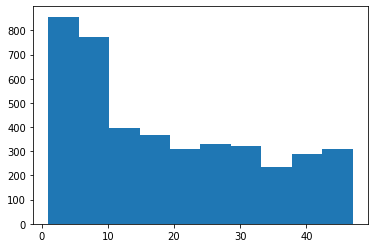

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(c_join["membership_period"])

In [20]:
c_end = c_join.loc[c_join["is_deleted"] == 1]
c_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [21]:
c_stay = c_join.loc[c_join["is_deleted"] == 0]
c_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000
